## Linear Regression vs Machine Learning Models

This notebook is designed to show some differences between linear regression and machine learning models. At the end of the day, our goal is to be able to predict future values. This notebook shows that in many cases, machine learning techniques are more effective than standard statistical techniques in improving predictions.

This notebook originally came from https://github.com/iam-mhaseeb/Predicting-Housing-Prices-with-Linear-Models.git

Start by installing/importing dependencies

In [1]:
!pip install xgboost

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import xgboost as xgb

Load the training and test data and take a look at it

In [18]:
import pandas as pd

df_train = pd.read_csv('train.csv')
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [19]:
df_test = pd.read_csv('test.csv')
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


Now let's do some filtering on our data by dropping the Id column

In [20]:
# Seprating Id from main data
train_id=df_train['Id']
test_id=df_test['Id']
df_train.drop("Id", axis = 1, inplace = True)
df_test.drop("Id", axis = 1, inplace = True)

Now let's visualize the data to see if there's anything strange going on

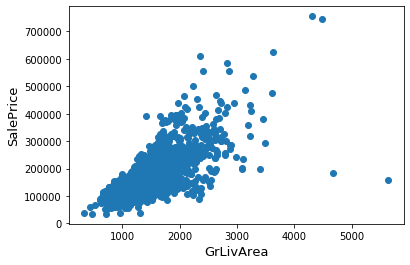

In [22]:
fig, ax = plt.subplots()
ax.scatter(x = df_train['GrLivArea'], y = df_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

We can see that there are some outliers where prices are greater than 4,000. Let's remove those outliers and re-plot

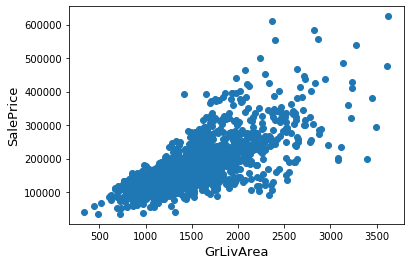

In [23]:
df_train = df_train.drop(df_train[(df_train['GrLivArea']>4000)].index)
fig, ax = plt.subplots()
ax.scatter(df_train['GrLivArea'], df_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

Now let's look at the distribution of the sale price to see if it follows a normal distribution

Text(0.5, 1.0, 'SalePrice distribution')

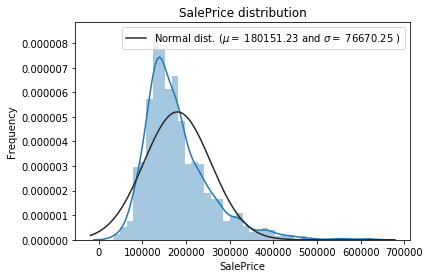

In [24]:
sns.distplot(df_train['SalePrice'] , fit=norm);
(mu, sigma) = norm.fit(df_train['SalePrice'])
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

We can see that sale price does not follow a normal distribution, so we can't use traditional linear regression techniques, unless we're able to normalize this field

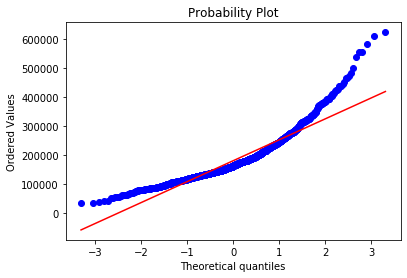

In [25]:
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)
plt.show()

It's pretty obvious from the graph above that our sale price is not linear. Let's take the log of the price to see if we can get it to fit a straight line

In [26]:
df_train["SalePrice"]=np.log1p(df_train["SalePrice"])

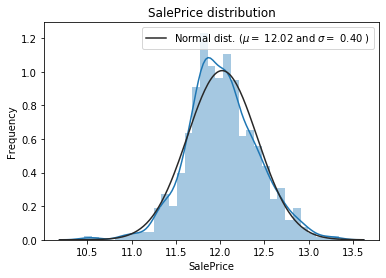

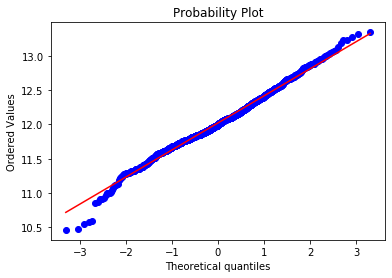

In [27]:
sns.distplot(df_train['SalePrice'] , fit=norm);
(mu, sigma) = norm.fit(df_train['SalePrice'])
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)
plt.show()

Ok, this looks pretty good now. The sale price now fits a normal distribution and appears to be linearly increasing, which now meet the basic requirements of using linear regression. Now fix any missing data fields

In [12]:
all_data = pd.concat((df_train, df_test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
all_data = pd.get_dummies(all_data)
all_data = all_data.fillna(all_data.mean())
X_train=all_data[:df_train.shape[0]]
X_test=all_data[:df_test.shape[0]]
y_train=df_train.SalePrice

Let's begin training. Start by creating a function to calculate root mean square error (RMSE). Keep in mind that RMSE is the standard deviation of the residuals (predicted values). Essentially, once we have a prediction, we calculate the square root of the sum of squares of the difference between the actual value and predicted value. This gives us a good estimate at the error of our model

In [28]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

Calculate the RMSE for a standard linear regression

In [29]:
model_LinearReg = LinearRegression()
model_LinearReg.fit(X_train, y_train)
rmse_LinearReg = rmse_cv(model_LinearReg).mean()
rmse_LinearReg

0.1285606186185095

Calculate the RMSE for a xgboost model

In [30]:
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test)
params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) 
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=360, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [31]:
rmse_xgb = model.values[-1,0]
rmse_xgb

0.068544

Let's try a couple of additional models. Here's RidgeCV

In [34]:
model_RidgeCV = RidgeCV()
model_RidgeCV.fit(X_train, y_train)
rmse_RidgeCV = rmse_cv(model_RidgeCV).mean()
rmse_RidgeCV

0.1152145818634599

And here's RandomForestRegressor

In [38]:
model_RandomForest=RandomForestRegressor()
model_RandomForest.fit(X_train,y_train)
rmse_RandomForest=rmse_cv(model_RandomForest).mean()
rmse_RandomForest

0.1386783807952227

Now let's graph the RMSE for each model to see how they all perform

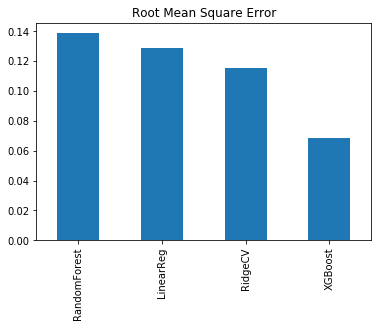

In [42]:
rmse_dict = {'data':[rmse_RandomForest, rmse_LinearReg, rmse_RidgeCV, rmse_xgb ]}
rmse_df = pd.DataFrame(data = rmse_dict, index = ['RandomForest','LinearReg','RidgeCV','XGBoost']) 
rmse_df.plot.bar(legend = False, title = 'Root Mean Square Error')